0.35


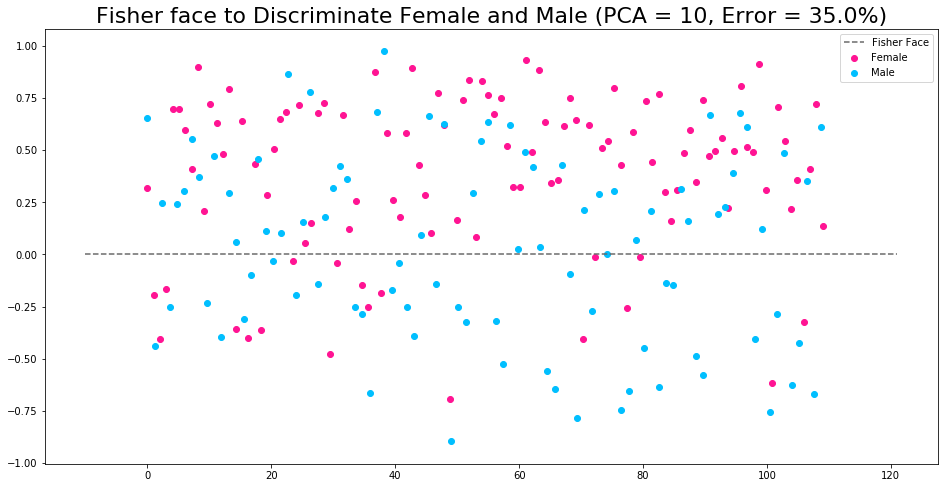

0.235


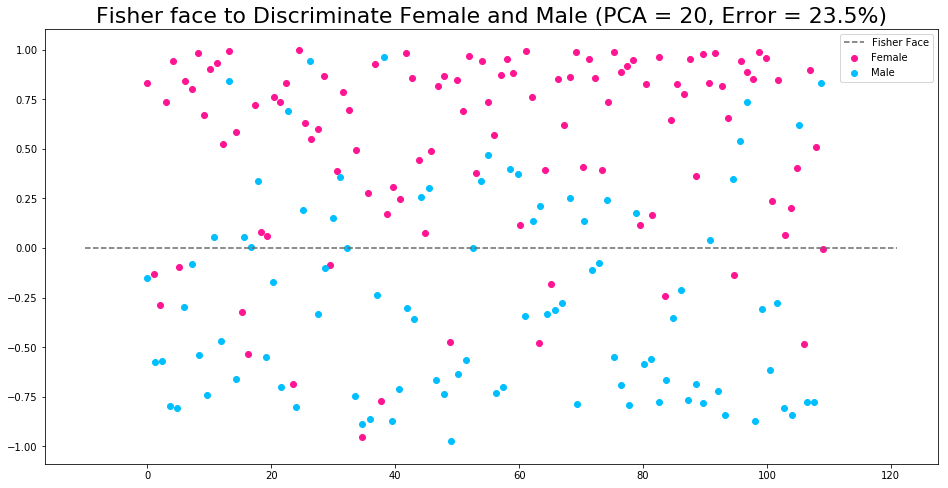

0.15


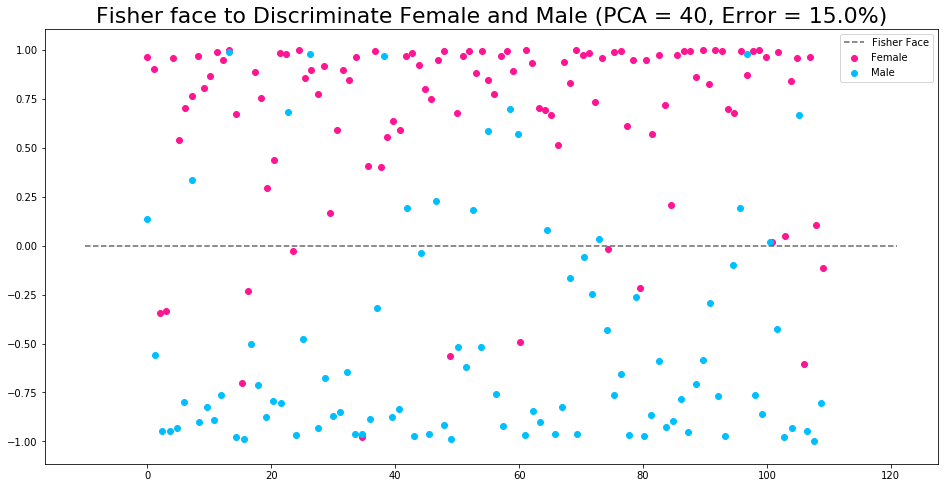

0.115


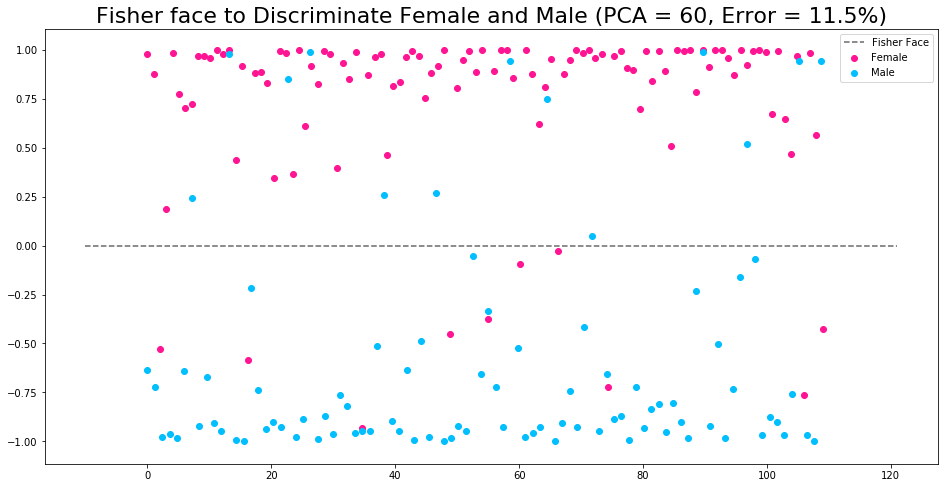

0.105


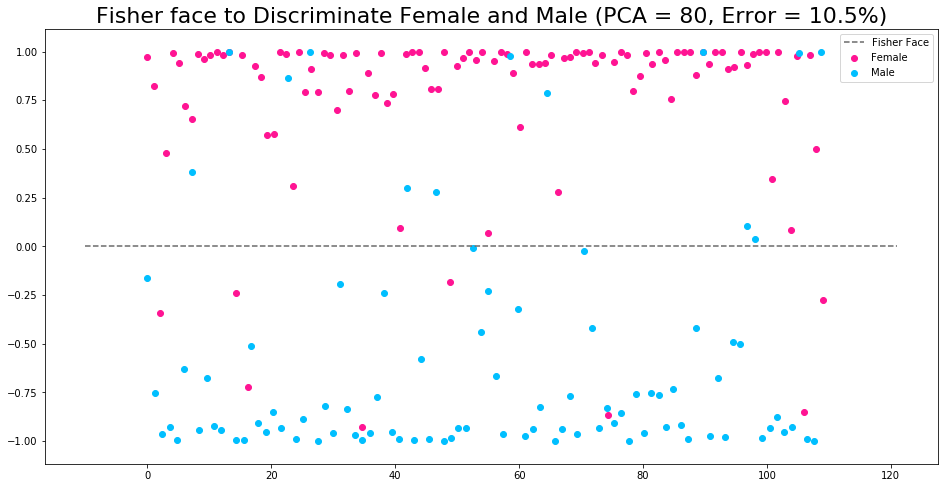

0.11


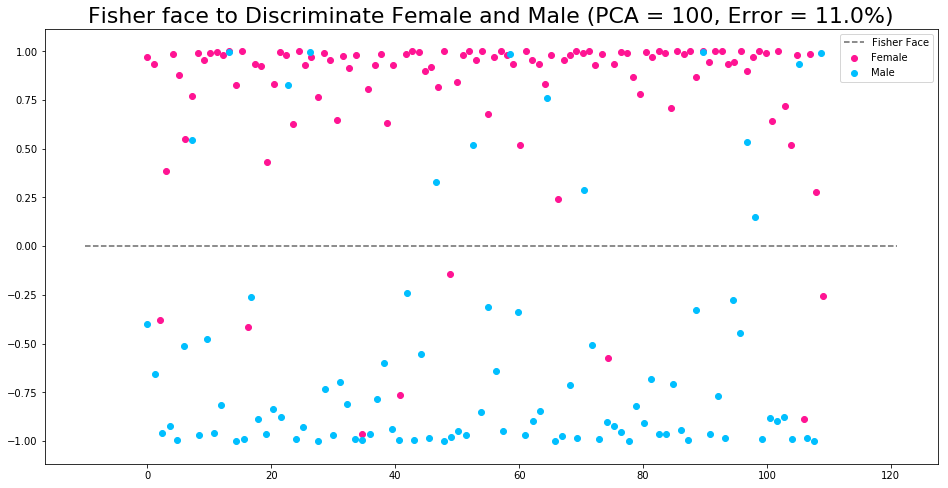

0.12


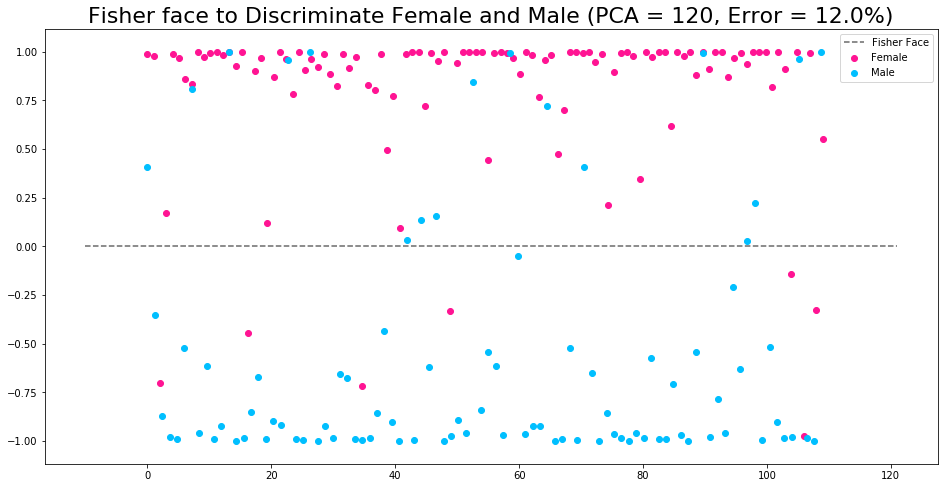

0.155


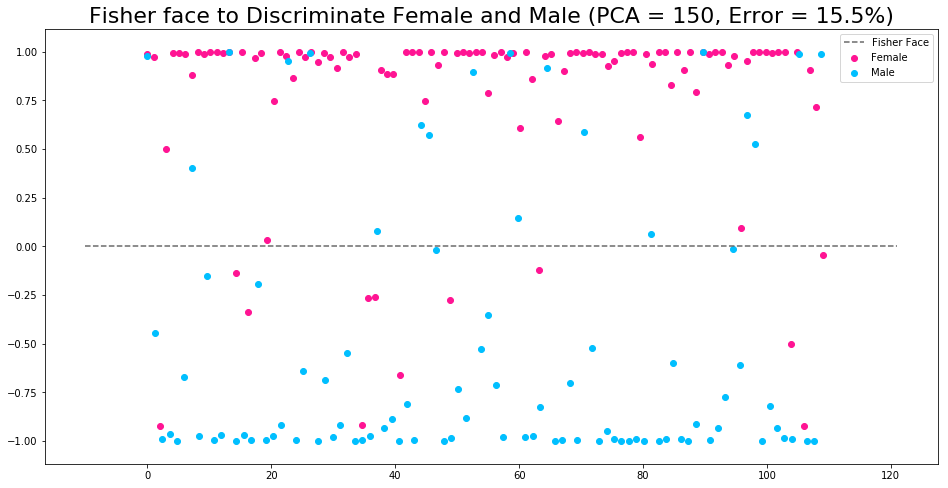

0.14


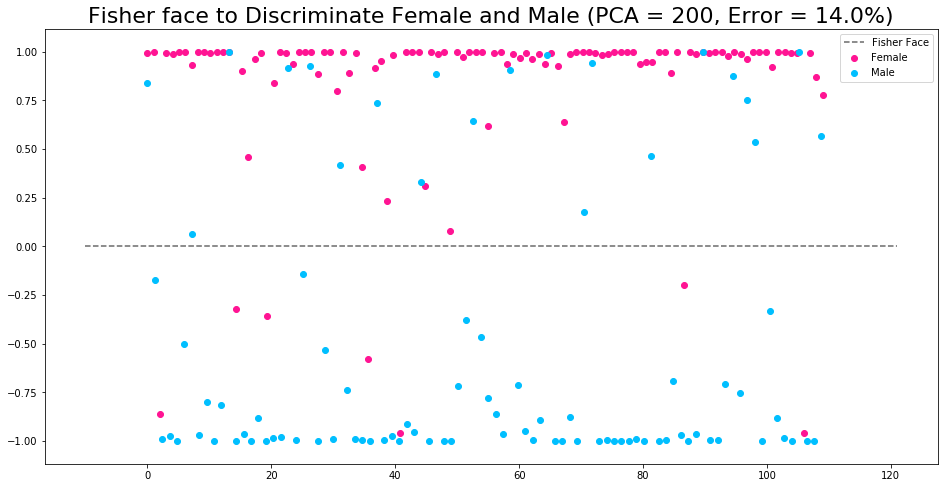

0.155


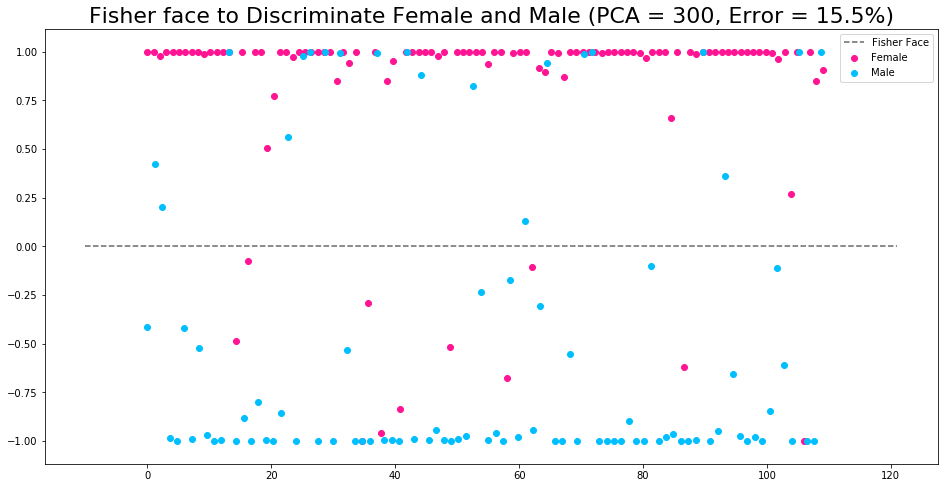

0.245


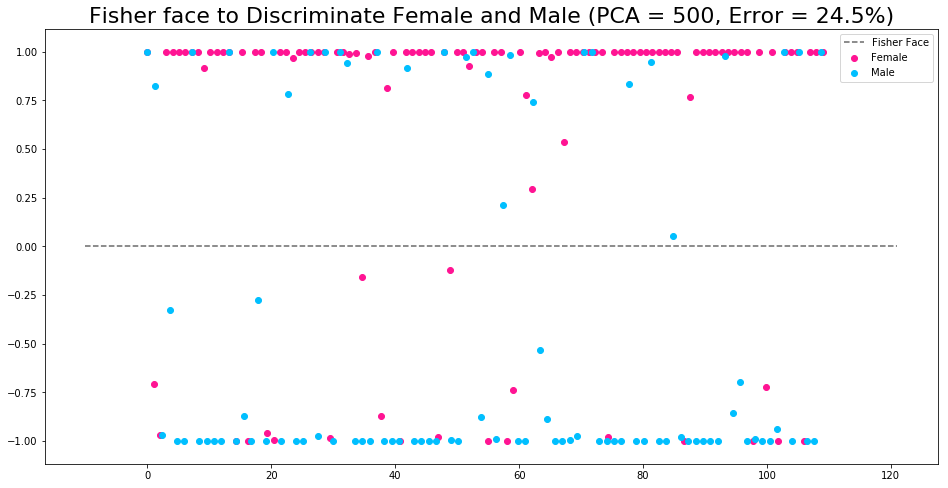

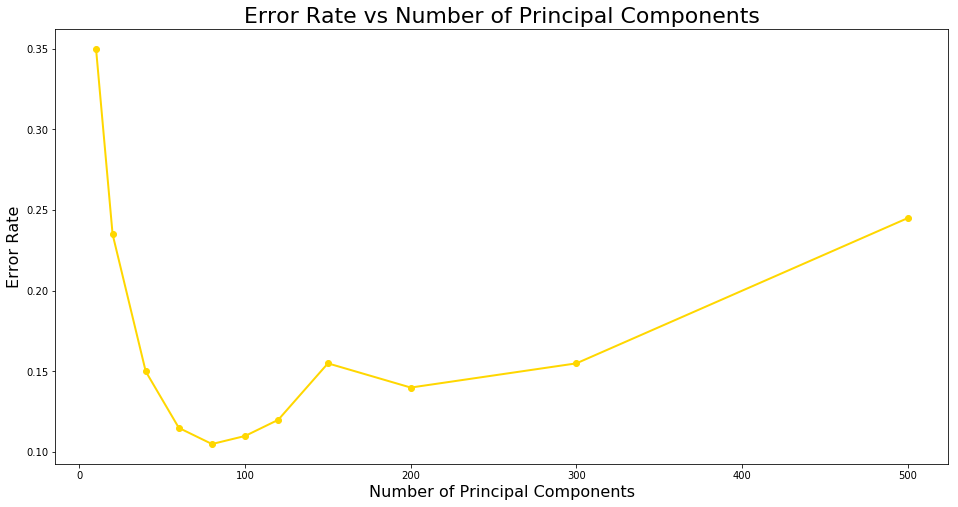

In [23]:
import matplotlib.pyplot as plt 
import matplotlib.image as img
import numpy as np
from skimage import color
from sklearn.decomposition import PCA
import os
import scipy
import math


# ============ preprocessing: index -> img_name, index -> landmarks ============ #
def read_files(path):
    file_list = os.listdir(path)
    file_list = [path + file for file in file_list]
    file_list.sort()
    return file_list


# ============ load data ============ #
# generate img list
female_img_path = read_files('female_images/')
female_imgs = np.array([img.imread(path) for path in female_img_path])
male_img_path = read_files('male_images/')
male_imgs = np.array([img.imread(path) for path in male_img_path])

# generate landmarks list
female_landmark_path = read_files('female_landmarks/')
female_landmarks = np.array([scipy.io.loadmat(path)['lms'] for path in female_landmark_path])
male_landmark_path = read_files('male_landmarks/')
male_landmarks = np.array([scipy.io.loadmat(path)['lms'] for path in male_landmark_path])


##############################################
#                   3.1
##############################################

# ============ process original data ============ #
x1 = np.array([img.flatten() for img in female_imgs])
x2 = np.array([img.flatten() for img in male_imgs])
X = np.r_[x1, x2]
y = np.hstack((np.zeros(588), np.ones(412)))


k_values = [10, 20, 40, 60, 80, 100, 120, 150, 200, 300, 500]
errors = []
for k in k_values:
    # ============ reduce dimensions ============ #
    pca = PCA(n_components = k)
    pca.fit(X)
    coef = np.dot(X, pca.components_.T)


    # ============ prepare train and test dataset ============ #
    num_female = 588
    num_male = 412

    train_female = 480
    test_female = num_female - train_female # 158
    train_male = 800 - train_female # 370
    test_male = num_male - train_male # 42

    train_x1 = coef[0:train_female]
    train_x2 = coef[num_female:num_female + train_male]
    train_y1 = y[0:train_female]
    train_y2 = y[num_female:num_female + train_male]
    train_x = np.r_[train_x1, train_x2]
    train_y = np.r_[train_y1, train_y2]
    test_x1 = coef[train_female:num_female]
    test_x2 = coef[num_female + train_male:1000]
    test_y1 = y[train_female:num_female]
    test_y2 = y[num_female + train_male:1000]
    test_x = np.r_[test_x1, test_x2]
    test_y = np.r_[test_y1, test_y2]


    # ============ find Fisher face ============ #
    from scipy import linalg
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib import colors

    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    lda.fit(train_x, train_y)

    # 0 - female. 1 - male
    xx1 = np.arange(len(test_x1)) / len(test_x1) * 110
    predx1 = lda.predict(test_x1)
    score1 = [fscore - mscore for (fscore, mscore) in lda.predict_proba(test_x1)]

    xx2 = np.arange(len(test_x2)) / len(test_x2) * 110
    predx2 = lda.predict(test_x2)
    score2 = [fscore - mscore  for (fscore, mscore) in lda.predict_proba(test_x2)]


    # ============ calculate error rate ============ #
    error = (sum(predx1) + len(score2) - sum(predx2)) / 200
    print(error)
    errors.append(error)


    # ============ plot data and Fisher face ============ #
    plt.figure(figsize=(16,8))
    plt.title('Fisher face to Discriminate Female and Male (PCA = ' + str(k) + \
              ', Error = ' + str(round(error*100, 2)) + '%)', fontsize=22)
    plt.scatter(x = xx1, y = score1, label='Female', color='deeppink')
    plt.scatter(x = xx2, y = score2, label='Male', color = 'deepskyblue')
    xx1 = np.arange(-10, 122, 1)
    plt.plot(xx1, 0 * xx1, color='dimgray', linestyle='--', label='Fisher Face')
    plt.legend(loc='best')
    plt.show()


# ============ plot error rate vs k ============ #
plt.figure(figsize=(16, 8))
plt.title('Error Rate vs Number of Principal Components', fontsize=22)
plt.xlabel('Number of Principal Components', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.plot(k_values, errors, color='gold', marker='o', lw=2)
plt.show()

0.05


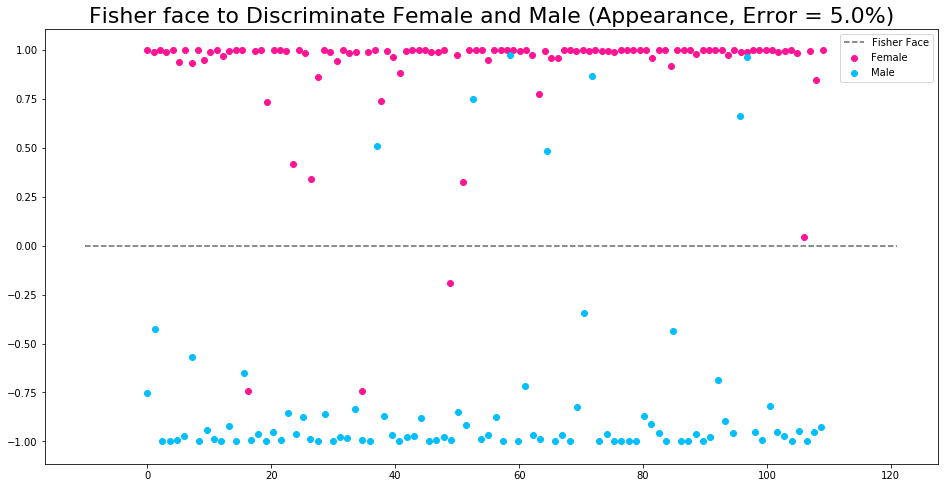

0.31


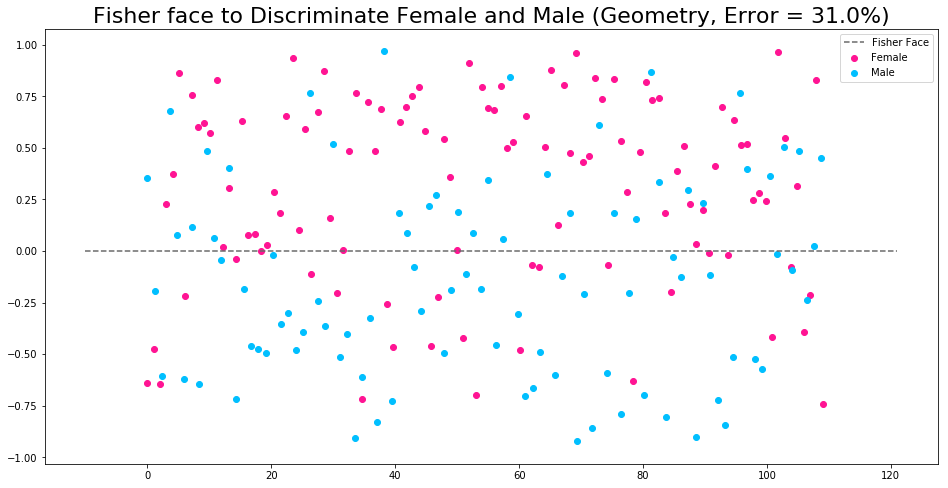

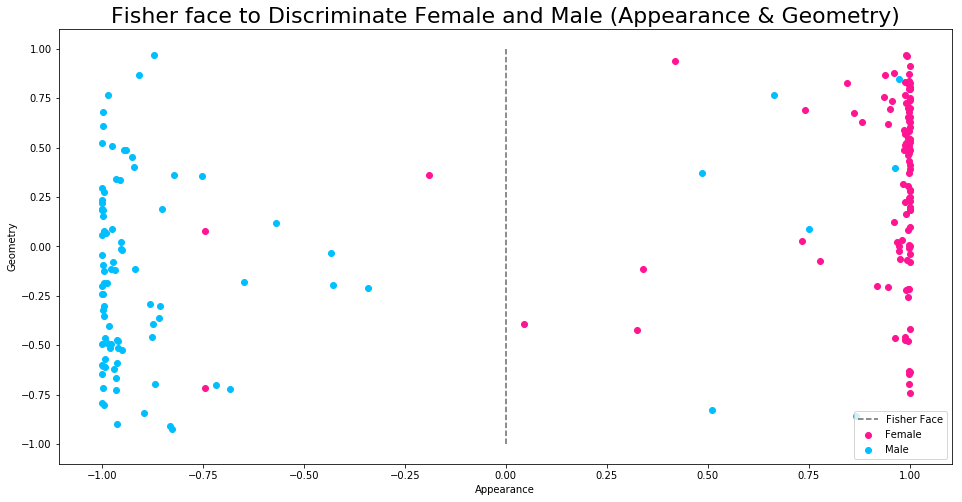

In [38]:
##############################################
#                   3.2
##############################################


from mywarper import warp

# ============ preprocess dataset (centralize and warp) ============ #
lms = np.r_[female_landmarks, male_landmarks]
# mean landmark
lm_mean = np.mean(lms, axis = 0)

landx1 = np.array([img.flatten() for img in female_landmarks])
landx2 = np.array([img.flatten() for img in male_landmarks])
landxs = np.r_[landx1, landx2]

imgs = np.r_[female_imgs, male_imgs]

imgs_aligned = np.array([warp(img, lm, lm_mean) for (img, lm) in zip(imgs, lms)])
imgsx = np.array([img.flatten() for img in imgs_aligned])

y = np.hstack((np.zeros(588), np.ones(412)))


# ============ PCA to reduce dimensions ============ #
from sklearn.decomposition import PCA

pca_appear = PCA(n_components = 50)
pca_appear.fit(imgsx)
coef_appear = np.dot(imgsx, pca_appear.components_.T)

pca_landmark = PCA(n_components = 10)
pca_landmark.fit(landxs)
coef_landmark = np.dot(landxs, pca_landmark.components_.T)


# ============ 1. prepare train and test dataset (appearance) ============ #
num_female = 588
num_male = 412

train_female = 480
test_female = num_female - train_female # 158
train_male = 800 - train_female # 370
test_male = num_male - train_male # 42

train_x1 = coef_appear[0:train_female]
train_x2 = coef_appear[num_female:num_female + train_male]
train_y1 = y[0:train_female]
train_y2 = y[num_female:num_female + train_male]
train_x = np.r_[train_x1, train_x2]
train_y = np.r_[train_y1, train_y2]
test_x1 = coef_appear[train_female:num_female]
test_x2 = coef_appear[num_female + train_male:1000]
test_y1 = y[train_female:num_female]
test_y2 = y[num_female + train_male:1000]
test_x = np.r_[test_x1, test_x2]
test_y = np.r_[test_y1, test_y2]


# ============ find Fisher face ============ #
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(train_x, train_y)


# 0 - female, 1 - male
xx1 = np.arange(len(test_x1)) / len(test_x1) * 110
predx1 = lda.predict(test_x1)
score1 = [fscore - mscore for (fscore, mscore) in lda.predict_proba(test_x1)]

xx2 = np.arange(len(test_x2)) / len(test_x2) * 110
predx2 = lda.predict(test_x2)
score2 = [fscore - mscore  for (fscore, mscore) in lda.predict_proba(test_x2)]


# ============ calculate error rate ============ #
error = (sum(predx1) + len(score2) - sum(predx2)) / 200
print(error)


# ============ plot data and Fisher face (appearance) ============ #
plt.figure(figsize=(16,8))
plt.title('Fisher face to Discriminate Female and Male (Appearance, ' + \
          'Error = ' + str(round(error*100, 2)) + '%)', fontsize=22)
plt.scatter(x = xx1, y = score1, label='Female', color='deeppink')
plt.scatter(x = xx2, y = score2, label='Male', color = 'deepskyblue')
xx1 = np.arange(-10, 122, 1)
plt.plot(xx1, 0 * xx1, color='dimgray', linestyle='--', label='Fisher Face')
plt.legend(loc='best')
plt.show()
    

# ============ 2. prepare train and test dataset (landmarks) ============ #
num_female = 588
num_male = 412

train_female = 480
test_female = num_female - train_female # 108
train_male = 800 - train_female # 320
test_male = num_male - train_male # 92

train_x1 = coef_landmark[0:train_female]
train_x2 = coef_landmark[num_female:num_female + train_male]
train_y1 = y[0:train_female]
train_y2 = y[num_female:num_female + train_male]
train_x = np.r_[train_x1, train_x2]
train_y = np.r_[train_y1, train_y2]
test_x1 = coef_landmark[train_female:num_female]
test_x2 = coef_landmark[num_female + train_male:1000]
test_y1 = y[train_female:num_female]
test_y2 = y[num_female + train_male:1000]
test_x = np.r_[test_x1, test_x2]
test_y = np.r_[test_y1, test_y2]


lda1 = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda1.fit(train_x, train_y)


# 0 - female, 1 - male
lm_xx1 = np.arange(len(test_x1)) / len(test_x1) * 110
lm_predx1 = lda1.predict(test_x1)
lm_score1 = [fscore - mscore for (fscore, mscore) in lda1.predict_proba(test_x1)]

lm_xx2 = np.arange(len(test_x2)) / len(test_x2) * 110
lm_predx2 = lda1.predict(test_x2)
lm_score2 = [fscore - mscore  for (fscore, mscore) in lda1.predict_proba(test_x2)]


# ============ calculate error rate ============ #
error = (sum(lm_predx1) + len(lm_score2) - sum(lm_predx2)) / 200
print(error)


# ============ plot data and Fisher face (appearance) ============ #
plt.figure(figsize=(16,8))
plt.title('Fisher face to Discriminate Female and Male (Geometry, ' + \
          'Error = ' + str(round(error*100, 2)) + '%)', fontsize=22)
plt.scatter(x = lm_xx1, y = lm_score1, label='Female', color='deeppink')
plt.scatter(x = lm_xx2, y = lm_score2, label='Male', color = 'deepskyblue')
xx1 = np.arange(-10, 122, 1)
plt.plot(xx1, 0 * xx1, color='dimgray', linestyle='--', label='Fisher Face')
plt.legend(loc='best')
plt.show()


# ============ 3. prepare train and test dataset (appearance & landmarks) ============ #
plt.figure(figsize=(16, 8))
plt.title('Fisher face to Discriminate Female and Male (Appearance & Geometry)', fontsize=22)
plt.scatter(x = score1, y = lm_score1, label='Female', color='deeppink')
plt.scatter(x = score2, y = lm_score2, label='Male', color='deepskyblue')
plt.plot([0, 0], [-1, 1], color='dimgray', linestyle='--', label='Fisher Face')

plt.xlabel('Appearance')
plt.ylabel('Geometry')
plt.legend(loc='best')

plt.show()
